<a href="https://colab.research.google.com/github/mshafi710/kttsdataenrichment/blob/main/Text_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TO DO


1.   If a word/senetence contains characters not in the list of kashmiri keyboard characters, reject that for simplicity purposes
2.   Also delete the outliers from the dataset (too long sentences and too short)

In [ ]:
#@title
# !pip install python-docx
# import docx
!pip install docx2txt
import docx2txt
from google.colab import drive
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import os
import pathlib
import logging
drive.mount('/content/drive')
# import nltk
import re
import pprint
from tqdm import tqdm
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3957 sha256=f6d1c3f59d94a40a4ad14fd2bb76b4f1860c596b9f65ca5cf514819ec296099e
  Stored in directory: /root/.cache/pip/wheels/22/58/cf/093d0a6c3ecfdfc5f6ddd5524043b88e59a9a199cb02352966
Successfully built docx2txt
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from IPython.display import display, HTML
css_classes = """
<style>
  h1, h2, h3, h4 {
    color: red;
    font-size: 16px;
  }

  p {
    font-size: 14px;
    color: var(--text-color);
  }
</style>
"""
import IPython


if IPython.get_ipython() is not None:
  def  print_heading(text: str) -> None:
    display(HTML(f'''{css_classes}<h5> {text} </h5>'''))

  def print_text(text : str, color : str ='grey') -> None:
    display (HTML(f''' {css_classes} <p style='--text-color:{color}'> {text}</p>'''))

else:
  def  print_heading(text : str) -> None:
    print("\n")
    print (text)
    print("\n")

  def print_text(text : str, color : str ='grey') -> None:
    print (text)

In [ ]:
''' This code assumes two directories in the working directory  of the project. one for holding the raw corpus and second for holding the processed corpus'''
class Corpus:
  _instance = None
  _summary_generatable = False
  _raw_corpus =""
  _vocab_size = 0
  _raw_corpus_size =0
  _total_sentences=0
  _sentence_char_lengths_list=list()
  _sentence_token_lengths_list=list()
  _basic_richness_list=list()
  _vocab= set()


  WORKING_DIR= '''/content/drive/MyDrive/PhD/Dataset/Text/text_files/'''
  VOCAB_FILENAME="kashmiri_vocab.csv"
  PROCESSED_DIR = 'processed'
  CORPUS_DIR= 'corpus'
  ENRICHED_FILENAME_INITIAL="initial_kashmiri_enriched.csv"
  ENRICHED_FILENAME_FINAL = "final_kashmiri_enriched.csv"
  # LOG_FILE = '/processed/text-extraction.log'
  #first letter in the TOKEN_DELIMITER_PATTERN is the Kashmiri fullstop character
  DIGIT_REPLACEMENT_PATTERN = r"[]"
  TOKEN_DELIMITER_PATTERN = r"[۔;,:\-\s+\n+\(\)\"\?,،!؟“’’’‘_''/]"
  SENTENCE_DELIMITER = r"[۔]"
  MINIMUM_SENTENCE_LENGTH=5


  #------- Functions -------
  def __new__(cls) -> "Corpus":
    if not cls._instance:
      cls._instance = super().__new__(cls)
      return cls._instance
    else:
      class_name = cls.__name__
      print("INFO! {} Class  is a Singleton ".format(class_name ))
      return cls._instance

  @classmethod
  def summary(cls) -> dict:
    if cls._summary_generatable:
      return {
          'vocab_size(tokens)': cls._vocab_size,
          'raw_corpus_size(tokens)': cls. _raw_corpus_size,
          'total_sentences' : cls. _total_sentences,
          'average_sentence_length_char': sum(cls._sentence_char_lengths_list)/cls. _total_sentences,
          'average_sentence_length_tokens': sum(cls._basic_richness_list)/ cls._total_sentences
      }
    else:
      return {'_summary_generatable':cls._summary_generatable }




  @classmethod
  def read_files(cls) -> None:
    corpus_path= os.path.join(cls.WORKING_DIR, cls.CORPUS_DIR )
    file_list= os.listdir(corpus_path)
    for filename in tqdm(file_list, unit='it', desc="Reading Corpus",  ncols=80 ):
      file_path = os.path.join(corpus_path, filename)  # Create the full file path
      if os.path.isfile(file_path):  # Check if it's a file (not a directory)
          # Process the file as needed
              print_text("Processing of [{}] file started".format(file_path))
              cls._raw_corpus = cls._raw_corpus + "\n" +  docx2txt.process(file_path)
              print_text("Processing of [{}] file ended".format(file_path))



  @classmethod
  def add_to_vocab(cls, sentence : str) -> None:
    ''' return the vocabulary list (unique words in the given list of sentences)
    writes vocab to the file with name in the VOCAB_FILE_NAME in the
    working directory  set by the variable  WORKING_DIR'''
    tokens = sentence.split()
    cls._raw_corpus_size += len(tokens)
    tokens.sort()
    cls._vocab= cls._vocab.union(set(tokens))

  @classmethod
  def save_vocab(cls) -> None:
    os.chdir(cls.WORKING_DIR)
    vocab_path = os.path.join(cls.WORKING_DIR , cls.PROCESSED_DIR , cls.VOCAB_FILENAME)
    with open (vocab_path,'w') as out:
      for token in tqdm(cls._vocab, unit='it', desc='Saving Vocabulary to a {}'.format(vocab_path), ncols=100):
        out.write(token+"\n")
    cls._vocab_size = len ( cls._vocab)

  @classmethod
  def sentence_richness(cls, sentence: str) -> int:
    '''return the basic richness of the sentence: basic richnes is
    equal to number of unique words in a sentence'''
    tokens= sentence.split()
    cls._sentence_token_lengths_list.append(len(tokens))
    richness = len(set(tokens))
    return  richness

  @classmethod
  def basic_richness_sentence_wise(cls) -> None:
    '''calculate the basic richnes of every valid sentence in the _raw_corpus.
    Basic richness is equal to the number of unique tokens in a sentence.'''
    sentences = re.split(cls.SENTENCE_DELIMITER,cls._raw_corpus)
    '''Filter out empty sentences while doing so, also replace the multiple
    spaces with one space, remove parenthesis, commas ,  quotes and alike
      as mentioned in the TOKEN_DELIMITER_PATTERN'''
    sentences = [re.sub(cls.TOKEN_DELIMITER_PATTERN, " ", sentence) \
                 for sentence in tqdm(sentences, unit= "it", \
                                      desc="Removing Punctuations and extra white spaces", ncols=80) if sentence.strip() ]
    cls._total_sentences = len(sentences)
    print("Total sentences: {}".format(cls._total_sentences))
    df= pd.DataFrame(columns=['sentence','richness'])
    sentences_skipped = 0
    for index, sentence in tqdm(enumerate(sentences), unit="item", desc="Calculating basic richness:", ncols=80):
      cls.add_to_vocab(sentence)
      if  len(sentence.split())>= cls.MINIMUM_SENTENCE_LENGTH:
        basic_richness= cls.sentence_richness(sentence)
        cls._basic_richness_list.append(basic_richness)
        cls._sentence_char_lengths_list.append(len(sentence))
        df.loc[len(df)] =[sentence, basic_richness]
      else:
        sentences_skipped += 1

    print("Sentences skipped due to length less than {}: {}".format(cls.MINIMUM_SENTENCE_LENGTH, sentences_skipped))
    cls.save_vocab()
    os.chdir(cls.WORKING_DIR)
    file_path = os.path.join(cls.WORKING_DIR, cls.PROCESSED_DIR, cls.ENRICHED_FILENAME_INITIAL)
    df.to_csv( file_path,index= False )
    print("Completed basic_richness_sentence_wise ")
    print("Total sentences saved: {}".format(len(df)))
    print_text("Info: Summary Available!", 'green')
    cls._summary_generatable=True

  @classmethod
  def generate_corpus_richness(cls) -> None:
    ''' reads the simple richness csv file pointed by ENRICHED_FILENAME_INITIAL into dataframe, sorts it
    in ascending order of richness, drops the rows with NaN values in richness column in place.
    Ascending order is used so that the small sentences are not deleted due to the large sentences having
    comparatively greater number of unique tokens leading to wishlist emptied soon and thus subsequent less richness is contributed.
    '''
    file_path = os.path.join (cls.WORKING_DIR, cls.PROCESSED_DIR, cls.ENRICHED_FILENAME_INITIAL)
    df=pd.read_csv(file_path)
    df.columns=  ['sentence','richness']
    df=df.sort_values(by=['richness'], ascending=True)
    #drops the old index and make the changes in the df directly
    df.reset_index(drop=True, inplace=True)
    #removes the dataframes where the richness column has missing or NaN values
    df=df.dropna(subset=['richness'])
    print("Total sentences remained after dropping NaN values: {}".format(len(df)))

    '''add a new column to the data frame for setting the status of whether any
    of the tokens of the sentence has matched to the wishlist or not. Initially
    all sentences will have tokens which are in the wishlist.
    Hence values are false for the new column.'''
    df=df.assign(Deleted=False)
    ''' calculate the richness of the sentences '''
    wishlist= cls._vocab
    total_deletable = 0
    print_heading("Initial Wishlist Length:{}".format(len(wishlist)))
    tbar = tqdm(df.iterrows(),total=len(df), unit='row', desc='Calculating final  richness: ', ncols=80)
    for index, row in  tbar:
        tokens= str(row['sentence']).split()
        tokens = [token for token in tokens if token.strip() ]
        tokens = set(tokens)

        ''' richness of a given sentence is the number of unique tokens matching
        with the remaining vocab list i.e., the intersection of the unique
        tokens (set) in the sentence and the remaining vocab'''
        match_words = tokens & wishlist
        not_matched = tokens - match_words
        if len(match_words) > 0:
          df.at[index,'richness'] = len(match_words)
          '''update the  wishlist by set difference operation of the wishlist
          and the match  tokens: excluding the matching tokens from the wishlist'''
          wishlist = wishlist - match_words
          tbar.set_description(desc='Wishlist Remaining Size :{} Words Matched: {}'.format(len(wishlist), len(match_words)))
        else:
          df.at[index,'Deleted']=True
          total_deletable +=1

    final_richness_file_path = os.path.join(cls.WORKING_DIR, cls.PROCESSED_DIR, cls.ENRICHED_FILENAME_FINAL)
    df.to_csv( final_richness_file_path )
    print_text('Final Richness saved to {}'.format(final_richness_file_path), "green")
    print_text('Total Deletable: {}'.format(total_deletable), 'red')
    # Validate the richness with the vocab size
    richness_sum_deleted_false= df.loc[df['Deleted'] == False, 'richness'].sum()
    vocab_len= len(cls._vocab)
    if( richness_sum_deleted_false == vocab_len):
      print_text('Richness  Validated with sum = {}'.format(richness_sum_deleted_false))

In [ ]:
mycorpus = Corpus()

In [ ]:
mycorpus.read_files()

Reading Corpus:   0%|                                     | 0/4 [00:00<?, ?it/s]

Reading Corpus:  25%|███████▎                     | 1/4 [00:01<00:03,  1.16s/it]

Reading Corpus:  50%|██████████████▌              | 2/4 [00:02<00:02,  1.48s/it]

Reading Corpus:  75%|█████████████████████▊       | 3/4 [00:15<00:06,  6.69s/it]

Reading Corpus: 100%|█████████████████████████████| 4/4 [00:22<00:00,  5.55s/it]


Calculating the vocabulary size of a text in a language with inflections can be challenging due to the presence of word variations caused by inflectional morphology. In such cases, multiple forms of a word can exist based on factors like tense, number, gender, case, etc. Here are a few approaches to estimate the vocabulary size:

1. **Lemmatization**: Apply lemmatization to reduce inflected words to their base or dictionary form (lemma). This process aims to normalize words and reduce them to their canonical form. After lemmatization, count the unique lemmas to estimate the vocabulary size.

2. **Stemming**: Use stemming techniques to reduce words to their root or stem form. Stemming is a simpler morphological process compared to lemmatization and may not always produce linguistically accurate stems. Counting the unique stems can provide an estimate of the vocabulary size.

3. **Frequency-based threshold**: Instead of considering every inflected form as a unique word, set a frequency threshold. For example, consider words that occur above a certain frequency (e.g., 5 occurrences) as separate words and group inflected forms below the threshold with their base form. This approach helps reduce vocabulary size while still accounting for commonly occurring inflected forms.

4. **Domain-specific analysis**: Analyze the specific domain or context of the text and identify common inflected forms or patterns. Grouping similar inflected forms together based on their shared base form or meaning can help in estimating the vocabulary size more accurately.

It's important to note that estimating vocabulary size in languages with inflections is not an exact science and can vary based on the specific language, corpus, and analysis approach. It is often a trade-off between capturing the richness of the language and reducing the vocabulary size for computational efficiency or analysis purposes.

Word with many inflective forms like
# **(آسمان, آسمانس, آسمانُک)**
are counted as many times.
Moreover, there are some words which might visually seem similar and should have been counted once but are constitutionally different.  E.g
# **آرگنائزیشن** and **آرگناٮٔزیشن**
upon deconstruction, it is found they differ in sixth character:
# **آرگنائ زیشن** and **آرگناٮٔ زیشن**

there  are also words which reflect dialectical differences like:
# **آزمانہٕ** and **آزماونہٕ**

In [ ]:
mycorpus.basic_richness_sentence_wise()

Removing Punctuations and extra white spaces: 100%|█| 13565/13565 [00:00<00:00, 


Total sentences: 13319


Calculating basic richness:: 13319item [00:50, 265.24item/s]


Sentences skipped due to length less than 5: 622


Saving Vocabulary to a /content/drive/MyDrive/PhD/Dataset/Text/text_files/processed/kashmiri_vocab.c


Completed basic_richness_sentence_wise 
Total sentences saved: 12697


In [ ]:
pprint.pprint(mycorpus.summary())

{'average_sentence_length_char': 107.05586004955327,
 'average_sentence_length_tokens': 17.540656205420827,
 'raw_corpus_size(tokens)': 250752,
 'total_sentences': 13319,
 'vocab_size(tokens)': 48959}


In [ ]:
mycorpus.generate_corpus_richness()

Total sentences remained after dropping NaN values: 12697


Wishlist Remaining Size :358 Words Matched: 16: 100%|█| 12697/12697 [00:56<00:00


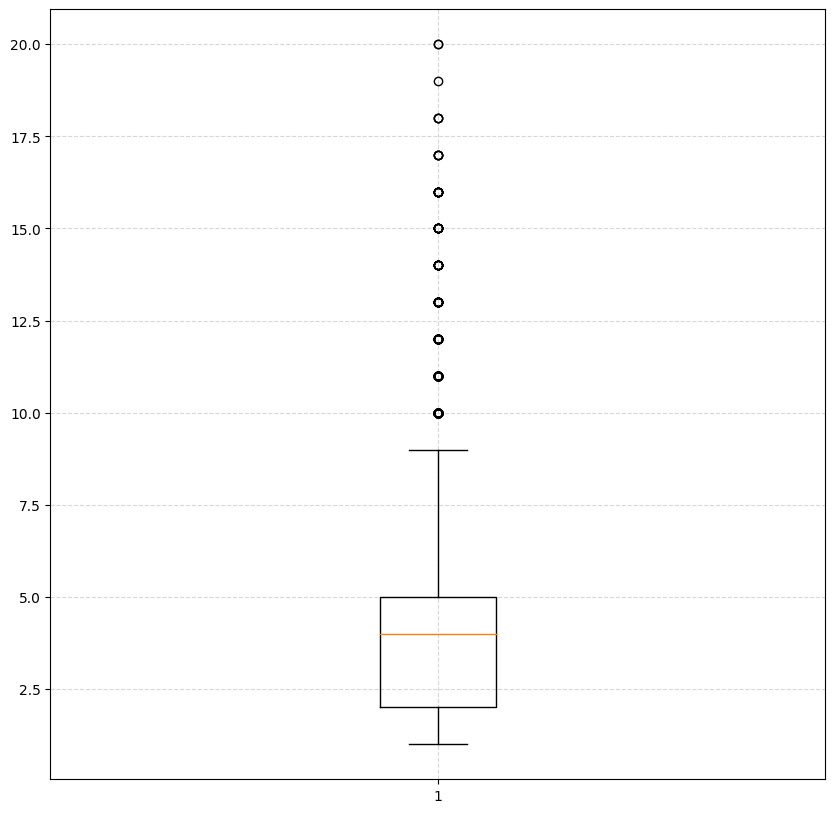

In [ ]:
df= pd.read_csv(os.path.join(Corpus.WORKING_DIR, Corpus.PROCESSED_DIR, Corpus.ENRICHED_FILENAME_FINAL))
 # Resetting the index
df = df.reset_index(drop=True)
condition = df['Deleted'] == False
plt.figure(figsize=(10, 10))
x= range(len(df[condition]['richness']))
plt.boxplot(df[condition]['richness'])
plt.grid(True, linestyle='--', alpha=0.5)

In [ ]:
data = df[condition]['richness']
q1, q3 = np.percentile(data, [25, 75])

# Calculate interquartile range (IQR)
iqr = q3 - q1

# Define outlier boundaries
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identify the outliers
outliers = [x for x in data if x < lower_bound or x > upper_bound]

# Calculate the number of outliers
num_outliers = len(outliers)

print_text("Number of outliers:{}".format(num_outliers), "red")
print("Percentage of outliers: {}".format(num_outliers /len(data) * 100 ))

Percentage of outliers: 1.9241698465535437


In [ ]:
data = df[condition]['richness']
removed = mycorpus._total_sentences - len(data)
print("{} total sentences removed ".format(removed))
print("{} is total sentences in the dataset with delete = False".format(len(data)))

1002 total sentences removed 
12317 is total sentences in the dataset with delete = False


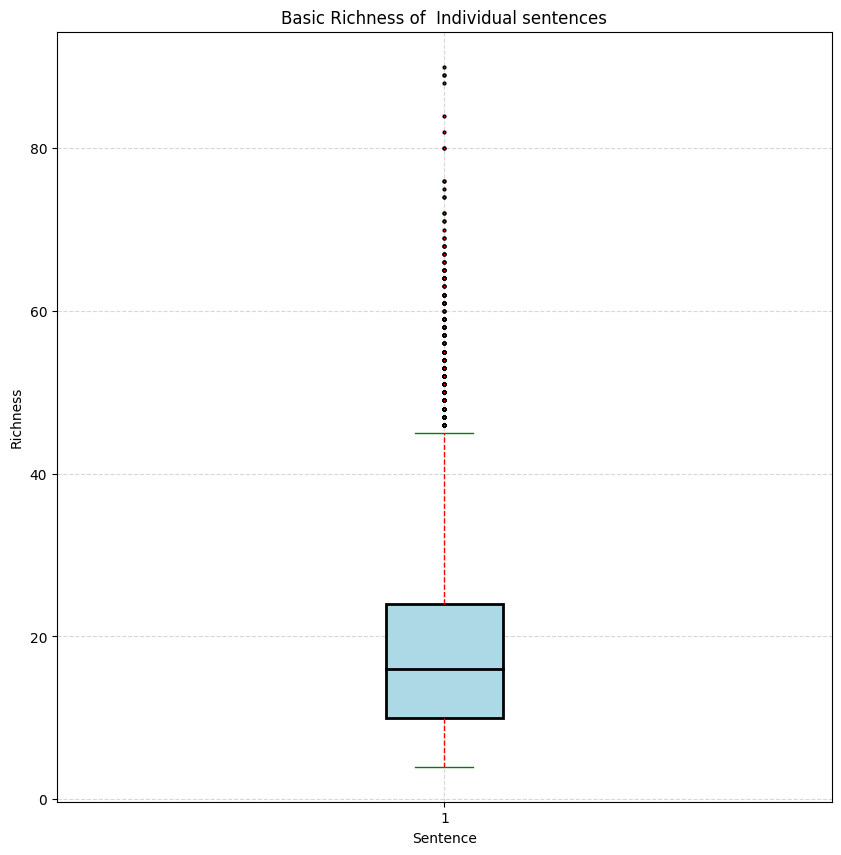

In [ ]:
plt.figure(figsize=(10, 10))
plt.boxplot(mycorpus._basic_richness_list, patch_artist=True,  boxprops=dict(facecolor='lightblue', linewidth=2), flierprops=dict(marker='.', markersize=4, markerfacecolor='red'),\
            capprops=dict(color='green'),\
            medianprops=dict(color='black', linewidth=2),\
            whiskerprops=dict(color='red', linestyle='--')
            )
# Adding gridlines
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Sentence')
plt.ylabel('Richness')
plt.title('Basic Richness of  Individual sentences')
plt.show()

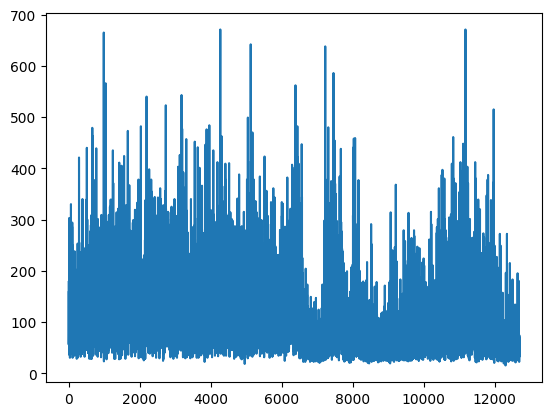

In [ ]:
plt.plot(mycorpus._sentence_char_lengths_list)

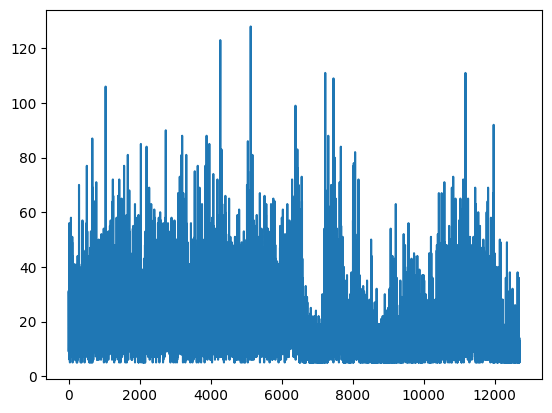

In [ ]:
plt.plot(mycorpus._sentence_token_lengths_list)

**check also the feasibility of TF-IDF for calculating the richness of the sentence or any other algorithm which can generate the smooth graph**

# **Statistics**

*   Total Number of Sentences
*   Total Number of Unique Words(Vocab Size)
*   Total Number of Words
*   Average Length of a sentence
*   Total Recorders
*   Total Reviewers
*   Total Recodings
*   Total Reviewed Recordings
*   Total Accepted Recordings
*   Total Rejected Recordings
*   Average Review of the Recordings
*   Box Plot of the length of the sentences
*   Normal Distribution Plot of the length of the sentences
*   Normal Distribution Plot of the length of the unique sentences


# New Richness algorithm based on TF-IDF